In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
train_df = pd.read_csv('train_copy.csv')
test_df = pd.read_csv('test_copy.csv')
test_df = test_df[train_df.columns.tolist()]

In [3]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=['number']).columns.tolist()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


def check_normalization(df):
    for col in df.columns:
        if df[col].max() > 1 or df[col].min() < 0:
            print(str(col) + ' is not normalized')
        else:
            print(str(col) + ' is normalized')


check_normalization(train_df[numerical_cols])

age is not normalized
wage_per_hour is not normalized
capital_gains is not normalized
capital_losses is not normalized
stock_dividends is not normalized
num_emp is not normalized
own_or_self is not normalized
weeks_worked is not normalized
year is not normalized
income_50k is normalized


In [5]:
X_train = train_df.drop('income_50k', axis=1)
y_train = train_df['income_50k']
X_test = test_df.drop('income_50k', axis=1)
y_test = test_df['income_50k']
numerical_cols = list(set(numerical_cols) - {'income_50k'})

In [6]:
# Create the preprocessor to encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)])

# Transform the train and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [7]:
target_groupby_df = train_df.groupby('income_50k').count()
target_groupby_df = target_groupby_df.iloc[:, 0]
target_groupby_df

income_50k
0    187141
1     12382
Name: age, dtype: int64

### Noticed that the traget data is highly unbalanced. Since some models are sensitive for unbalanced class, then it may lead to overfitting problems. To balance the dataset, we shall use oversampling.

In [8]:
# Instantiate SMOTE
rus = RandomUnderSampler(random_state=42)
# Resample training data
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [9]:
# Define the models
models = [
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(max_iter=1000),
        'hyperparameters': {
            'C': [0.1, 0.5, 1, 5, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'estimator': KNeighborsClassifier(),
        'hyperparameters': {
            'n_neighbors': [5, 10, 20],
        }
    },
    {
        'name': 'Decision Tree',
        'estimator': DecisionTreeClassifier(),
        'hyperparameters': {
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    },
    {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    },
    {
        'name': 'AdaBoost',
        'estimator': AdaBoostClassifier(),
        'hyperparameters': {
            'n_estimators': [10, 50, 100],
            'learning_rate': [0.1, 0.5, 1.0],
        }
    }

]

In [10]:
# Loop through the models and perform cross-validation to select model parameters
for model in models:
    print(model['name'])
    grid_search = GridSearchCV(model['estimator'], model['hyperparameters'], cv=5)
    grid_search.fit(X_train_res, y_train_res)
    print('Best parameters:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_)
    print()
    model['best_estimator'] = grid_search.best_estimator_

Logistic Regression
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8688011736820458

K-Nearest Neighbors
Best parameters: {'n_neighbors': 20}
Best score: 0.8544659296580098

Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 5}
Best score: 0.8503873731329751

Random Forest
Best parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Best score: 0.8720721306941144

AdaBoost
Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best score: 0.8715875595704631



In [11]:
models_name_list = [model['name'] for model in models]
pred_output = pd.DataFrame(y_test)

In [12]:
for model in models:
    model_name = model['name']
    print(model_name)
    y_pred = model['best_estimator'].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.2f}')
    pred_output[str(model_name)] = y_pred
    print()


Logistic Regression
Test accuracy: 0.84

K-Nearest Neighbors
Test accuracy: 0.83

Decision Tree
Test accuracy: 0.83

Random Forest
Test accuracy: 0.84

AdaBoost
Test accuracy: 0.85



In [13]:
pred_output

,income_50k,Logistic Regression,K-Nearest Neighbors,Decision Tree,Random Forest,AdaBoost
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,1,1,1,1
...,...,...,...,...,...,...
99757,0,0,0,0,0,0
99758,0,0,1,1,0,0
99759,0,0,0,0,0,0
99760,0,1,1,1,1,1


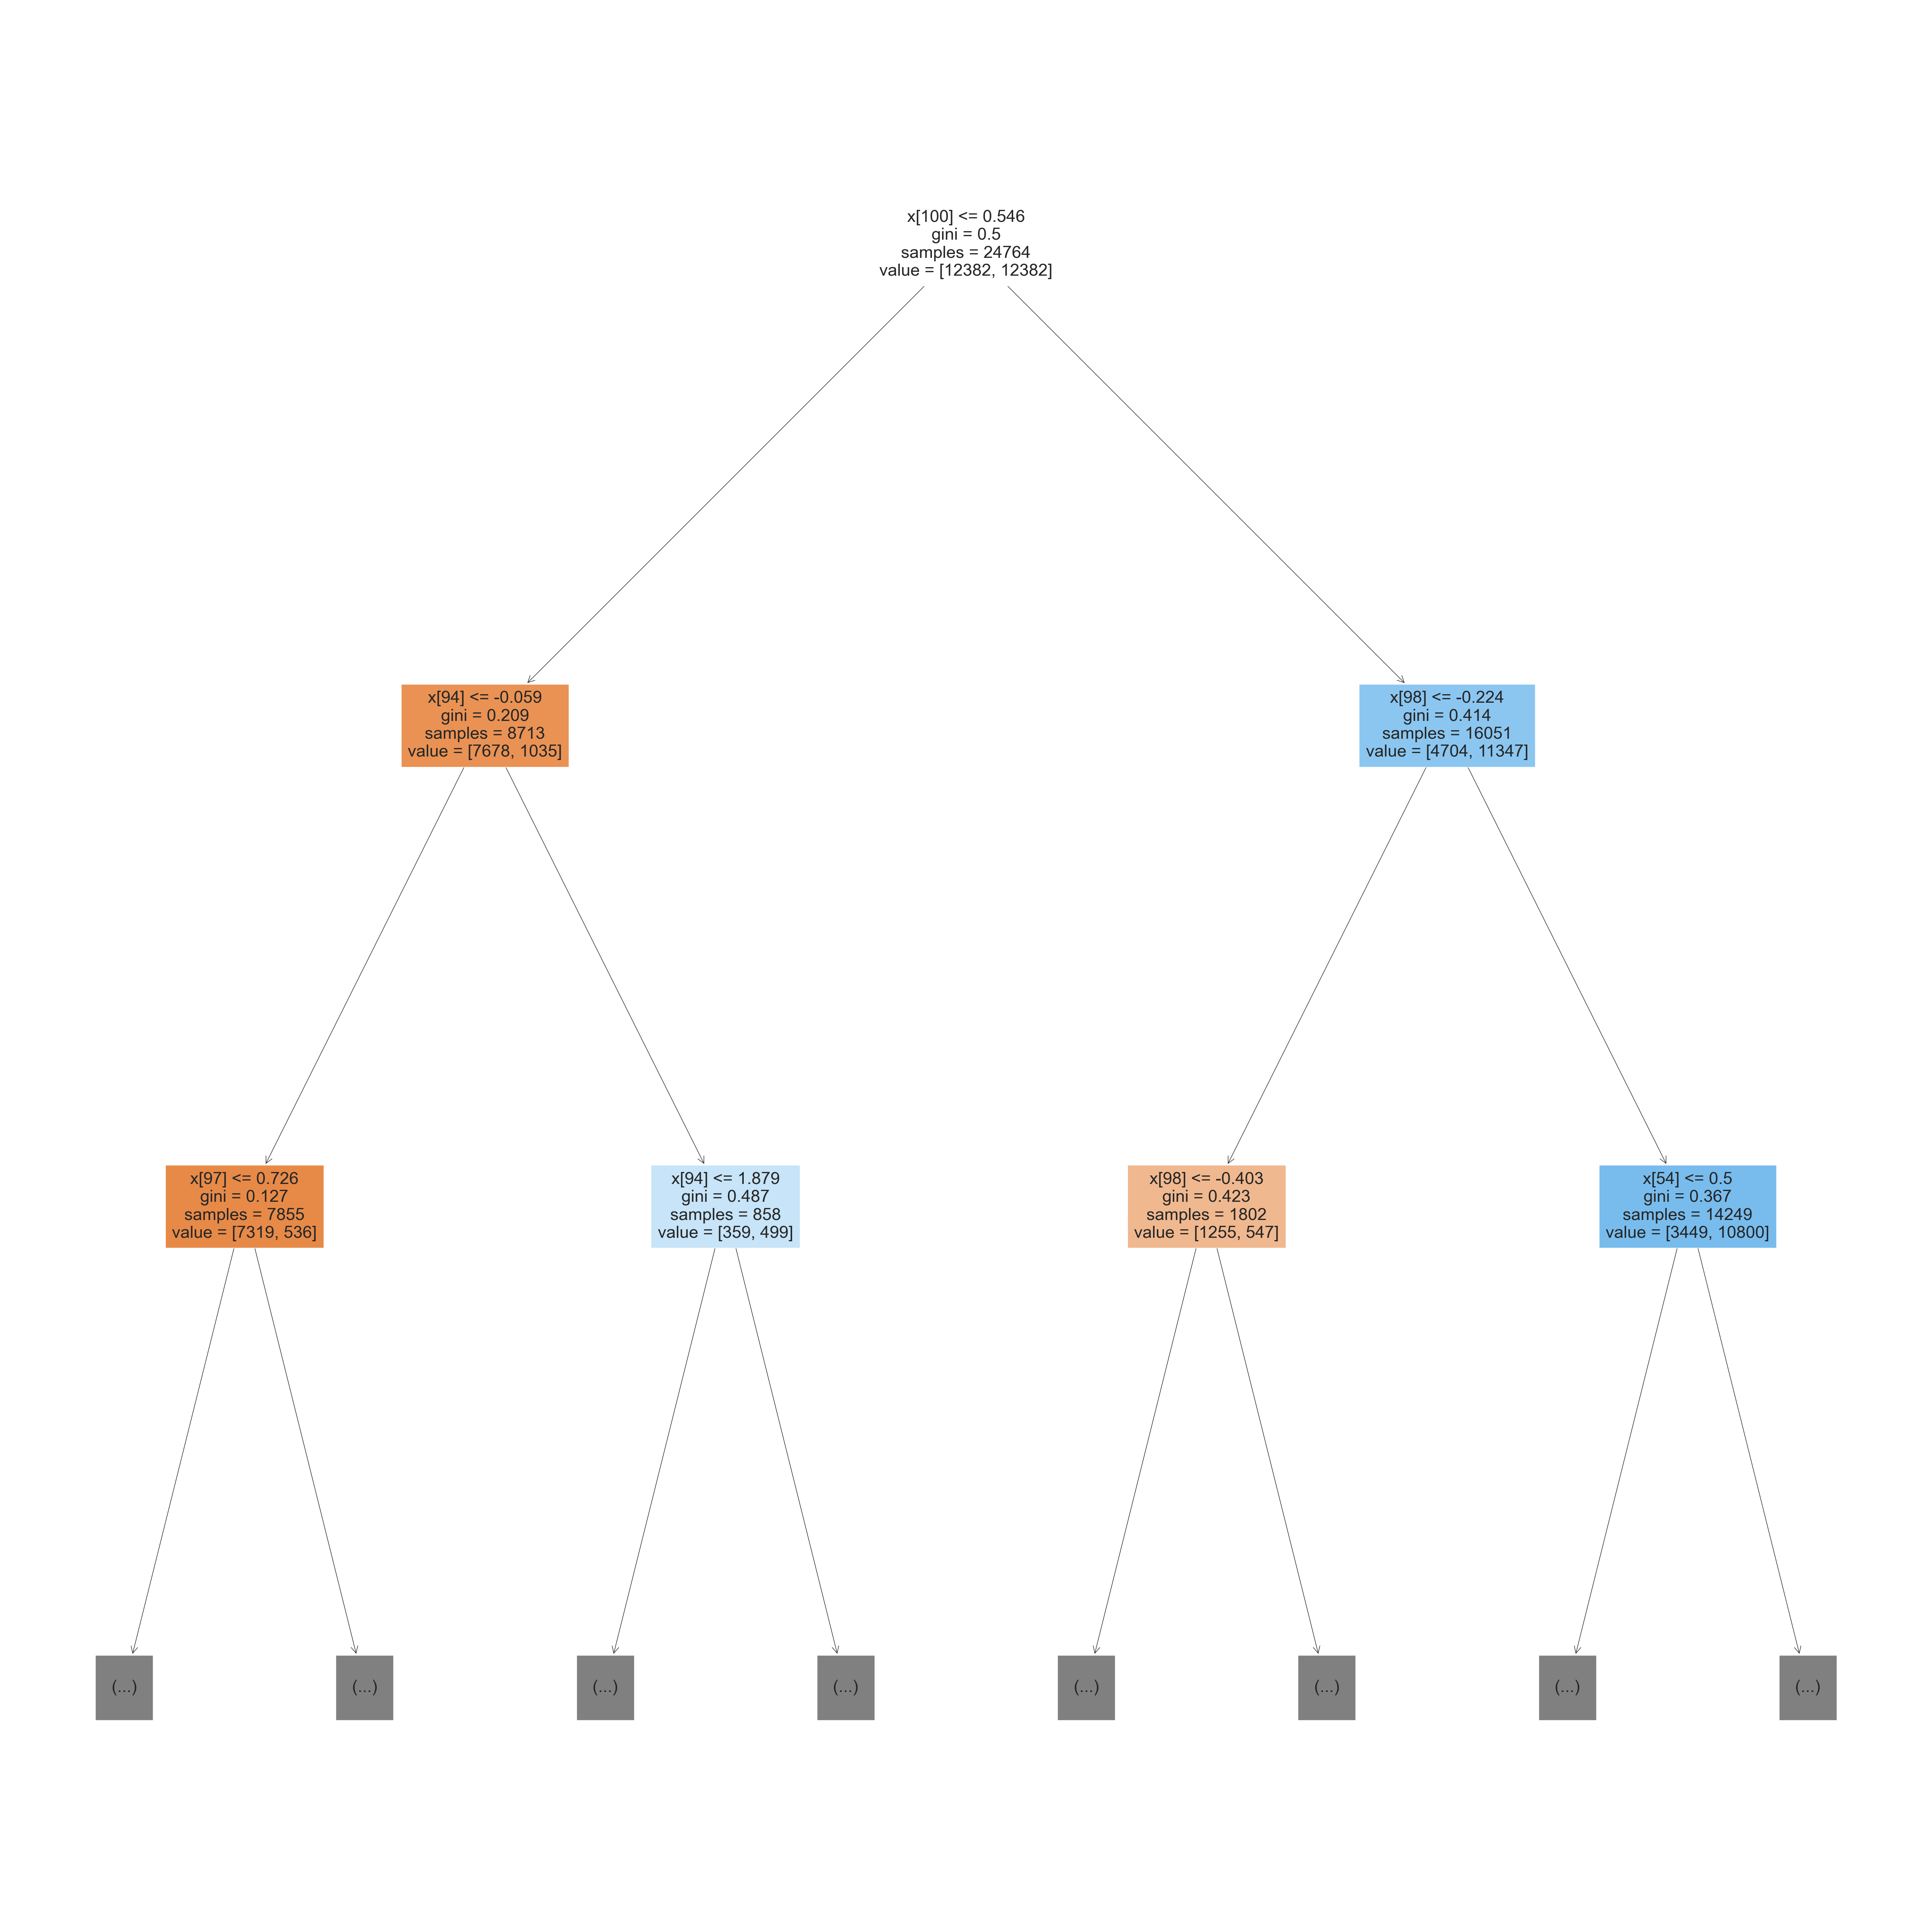

In [14]:
plt.figure(figsize=(50, 50))
plot_tree(models[2]['best_estimator'], filled=True, max_depth=2)
plt.tight_layout()
plt.show()

In [15]:
#pred_output.to_csv('y_true_vs_y_pred.csv',index=False)

In [16]:
models_name_list

['Logistic Regression',
 'K-Nearest Neighbors',
 'Decision Tree',
 'Random Forest',
 'AdaBoost']

In [17]:
y_true = pred_output['income_50k']
predictions = pred_output[models_name_list].T.to_numpy()

In [89]:
from sklearn.metrics import classification_report, cohen_kappa_score, recall_score, precision_score, f1_score


def model_accuracy_check(models, y_true, y_pred_array, plot_cm=False, show_report=False):
    accuracies = []
    kappa_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    classification_report_dict_list = []

    for i in range(len(models)):
        acc = accuracy_score(y_true, y_pred_array[i])
        accuracies.append(acc)
        print(f'Model {models[i]}: Accuracy = {np.round(acc, 2)}')
        kappa = cohen_kappa_score(y_true, y_pred_array[i])
        print('Kappa: ', np.round(kappa, 2))
        kappa_list.append(kappa)
        recall = recall_score(y_true, y_pred_array[i])
        print('Recall: ', np.round(recall, 2))
        recall_list.append(recall)
        precision = precision_score(y_true, y_pred_array[i])
        print('Precision: ', np.round(precision, 2))
        precision_list.append(precision)
        f1 = f1_score(y_true, y_pred_array[i])
        print('Recall: ', np.round(f1, 2))
        f1_score_list.append(f1)
        print()
    sns.barplot(x=models, y=accuracies)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Classification Models')
    plt.show()
    print()
    accuracies_df = pd.DataFrame(
        {'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost'], 'Accuracy': accuracies,
         'Precision': precision_list, 'Recall': recall_list, 'F1_score': f1_score_list, 'Kappa': kappa_list})
    if plot_cm == True:
        print('Confusion Matrix Plots: \n')
        for i in range(len(models)):
            cm = confusion_matrix(y_true, predictions[i])
            print(f'Model {models[i]}:')
            print(cm)
            sns.heatmap(cm, annot=True, cmap='coolwarm')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix: ' + str(models[i]))
            plt.show()
    print()
    if show_report == True:
        for i in range(len(models)):
            cr = classification_report(y_true, predictions[i],output_dict=True)
            print(f'Classification Report: {models[i]}')
            print(classification_report(y_true, predictions[i],output_dict=False))
            classification_report_dict_list.append(cr)

    return accuracies_df,classification_report_dict_list



Model Logistic Regression: Accuracy = 0.84
Kappa:  0.35
Recall:  0.9
Precision:  0.27
Recall:  0.41

Model K-Nearest Neighbors: Accuracy = 0.83
Kappa:  0.32
Recall:  0.89
Precision:  0.25
Recall:  0.39

Model Decision Tree: Accuracy = 0.83
Kappa:  0.33
Recall:  0.87
Precision:  0.25
Recall:  0.39

Model Random Forest: Accuracy = 0.84
Kappa:  0.35
Recall:  0.91
Precision:  0.27
Recall:  0.41

Model AdaBoost: Accuracy = 0.85
Kappa:  0.37
Recall:  0.9
Precision:  0.28
Recall:  0.43



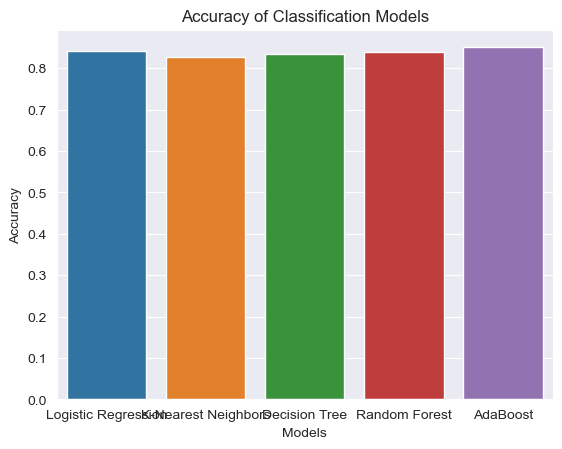



Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     93576
           1       0.27      0.90      0.41      6186

    accuracy                           0.84     99762
   macro avg       0.63      0.87      0.66     99762
weighted avg       0.95      0.84      0.88     99762

Classification Report: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     93576
           1       0.25      0.89      0.39      6186

    accuracy                           0.83     99762
   macro avg       0.62      0.86      0.64     99762
weighted avg       0.95      0.83      0.87     99762

Classification Report: Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     93576
           1       0.25      0.87      0.39      6186

    accuracy                           0.83     99762
   

In [90]:
accuracies_df,classification_report_dict_list = model_accuracy_check(models_name_list, y_true, predictions, plot_cm=False, show_report=True)


In [91]:
accuracies_df.round(2)

,Model,Accuracy,Precision,Recall,F1_score,Kappa
0,Logistic Regression,0.84,0.27,0.90,0.41,0.35
1,KNN,0.83,0.25,0.89,0.39,0.32
2,Decision Tree,0.83,0.25,0.87,0.39,0.33
3,Random Forest,0.84,0.27,0.91,0.41,0.35
4,AdaBoost,0.85,0.28,0.90,0.43,0.37


In [92]:
info_df_false_list = []
info_df_true_list = []
for i in range(len(models_name_list)):
    info_df_false = pd.DataFrame(classification_report_dict_list[i]['0'],index=[models_name_list[i]])
    info_df_false_list.append(info_df_false)
    info_df_true = pd.DataFrame(classification_report_dict_list[i]['1'],index=[models_name_list[i]])
    info_df_true_list.append(info_df_true)
info_df_true_all = pd.concat(info_df_true_list,axis=0)
info_df_false_all = pd.concat(info_df_false_list,axis=0)


In [93]:
info_df_true_all.round(2)

,precision,recall,f1-score,support
Logistic Regression,0.27,0.90,0.41,6186
K-Nearest Neighbors,0.25,0.89,0.39,6186
Decision Tree,0.25,0.87,0.39,6186
Random Forest,0.27,0.91,0.41,6186
AdaBoost,0.28,0.90,0.43,6186


In [94]:
info_df_false_all.round(2)

,precision,recall,f1-score,support
Logistic Regression,0.99,0.84,0.91,93576
K-Nearest Neighbors,0.99,0.82,0.90,93576
Decision Tree,0.99,0.83,0.90,93576
Random Forest,0.99,0.83,0.91,93576
AdaBoost,0.99,0.85,0.91,93576


In [95]:
accuracies_df.round(4).to_latex(index=False)

/var/folders/_j/x8h1yttn1s76k8f3bvjm72rw0000gn/T/ipykernel_61146/2060195162.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  accuracies_df.round(4).to_latex(index=False)


'\\begin{tabular}{lrrrrr}\n\\toprule\n              Model &  Accuracy &  Precision &  Recall &  F1\\_score &  Kappa \\\\\n\\midrule\nLogistic Regression &    0.8425 &     0.2694 &  0.8999 &    0.4147 & 0.3529 \\\\\n                KNN &    0.8264 &     0.2491 &  0.8928 &    0.3895 & 0.3239 \\\\\n      Decision Tree &    0.8335 &     0.2546 &  0.8747 &    0.3944 & 0.3301 \\\\\n      Random Forest &    0.8392 &     0.2666 &  0.9100 &    0.4124 & 0.3501 \\\\\n           AdaBoost &    0.8506 &     0.2800 &  0.8967 &    0.4267 & 0.3669 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [96]:
accuracies_df

,Model,Accuracy,Precision,Recall,F1_score,Kappa
0,Logistic Regression,0.842465,0.269406,0.899935,0.414674,0.352914
1,KNN,0.826437,0.249064,0.892823,0.389479,0.323922
2,Decision Tree,0.833454,0.254623,0.874717,0.394431,0.330082
3,Random Forest,0.839217,0.266626,0.909958,0.412411,0.350076
4,AdaBoost,0.850584,0.279954,0.896702,0.426692,0.366854


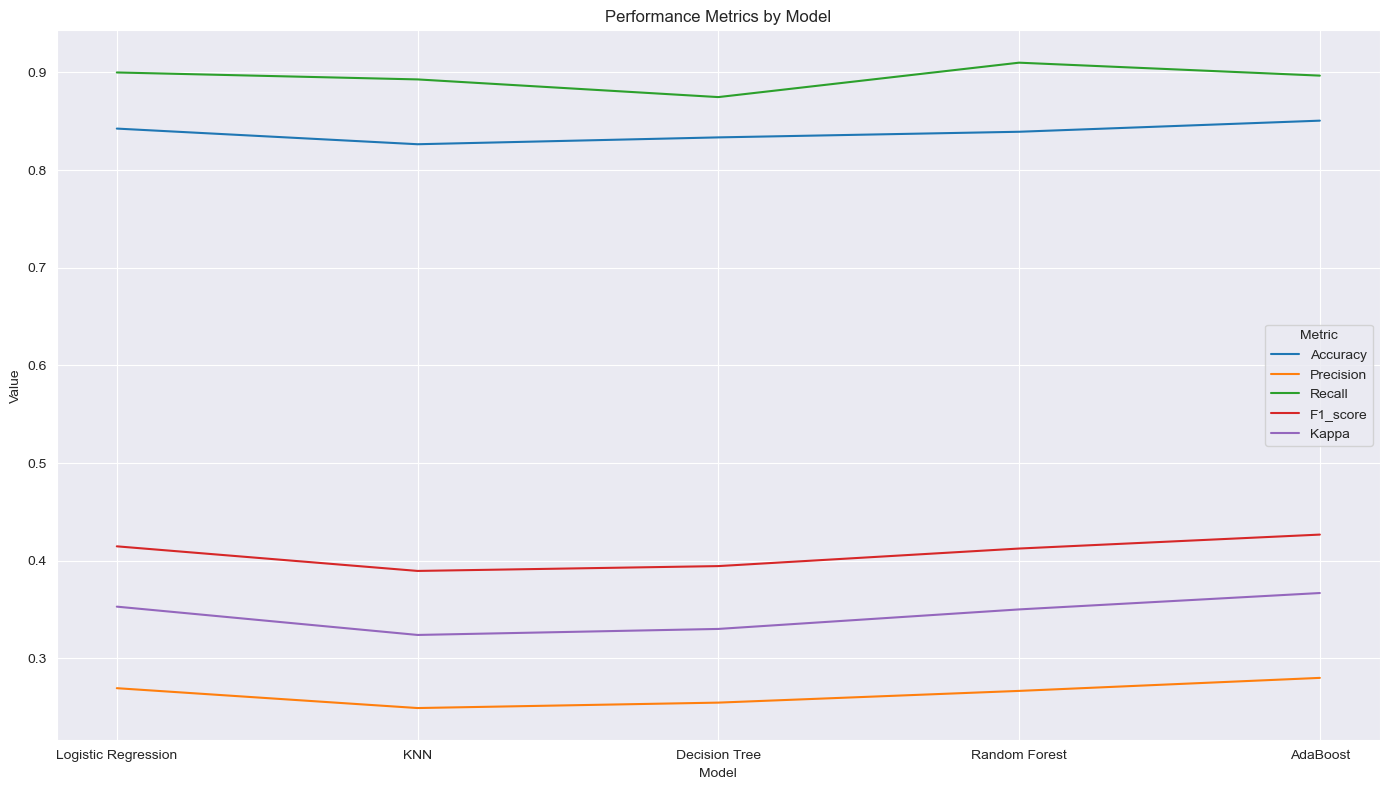

In [102]:
# Melt the DataFrame to make it easier to plot
melted_df = pd.melt(accuracies_df, id_vars=['Model'], var_name='Metric', value_name='Value')
# Create the bar plot using seaborn
plt.figure(figsize=(14,8))
sns.lineplot(x='Model', y='Value', hue='Metric', data=melted_df)
plt.title('Performance Metrics by Model')
plt.tight_layout()
plt.show()

## Use Cross_Validation to test model performance again

In [44]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df

,age,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,weeks_worked,year,class_worker,...,race,sex,union_member,full_or_part_emp,tax_filer_stat,det_hh_summ,mig_same,fam_under_18,citizenship,income_50k
0,73,0,0,0,0,0,0,0,95,Not in universe,...,White,Female,Not in universe,Not in labor force,Nonfiler,Other relative of householder,Not in universe under 1 year old,Not in universe,Native- Born in the United States,0
1,58,0,0,0,0,1,0,52,94,Self-employed-not incorporated,...,White,Male,Not in universe,Children or Armed Forces,Head of household,Householder,No,Not in universe,Native- Born in the United States,0
2,18,0,0,0,0,0,0,0,95,Not in universe,...,Asian or Pacific Islander,Female,Not in universe,Not in labor force,Nonfiler,Child 18 or older,Not in universe under 1 year old,Not in universe,Foreign born- Not a citizen of U S,0
3,9,0,0,0,0,0,0,0,94,Not in universe,...,White,Female,Not in universe,Children or Armed Forces,Nonfiler,Child under 18 never married,Yes,Both parents present,Native- Born in the United States,0
4,10,0,0,0,0,0,0,0,94,Not in universe,...,White,Female,Not in universe,Children or Armed Forces,Nonfiler,Child under 18 never married,Yes,Both parents present,Native- Born in the United States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,0,0,0,0,0,0,0,95,Not in universe,...,White,Female,Not in universe,Children or Armed Forces,Nonfiler,Child under 18 never married,Not in universe under 1 year old,Both parents present,Native- Born in the United States,0
99758,61,0,0,0,0,4,0,52,95,Private,...,Black,Male,No,Full-time schedules,Single,Householder,Not in universe under 1 year old,Not in universe,Native- Born in the United States,0
99759,24,0,0,0,0,2,0,52,94,Self-employed-not incorporated,...,White,Male,Not in universe,Children or Armed Forces,Joint both under 65,Nonrelative of householder,Yes,Not in universe,Foreign born- U S citizen by naturalization,0
99760,30,0,0,0,0,5,0,52,95,Private,...,White,Female,Not in universe,Full-time schedules,Joint both under 65,Spouse of householder,Not in universe under 1 year old,Not in universe,Native- Born in the United States,0


In [10]:
all_features = all_df.drop('income_50k', axis=1)
all_target = all_df['income_50k']
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)])
all_features_transformed = preprocessor2.fit_transform(all_features)

In [11]:
all_target

0        0
1        0
2        0
3        0
4        0
        ..
99757    0
99758    0
99759    0
99760    0
99761    0
Name: income_50k, Length: 299285, dtype: int64

In [12]:
all_df.groupby('income_50k').count()

,age,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,weeks_worked,year,class_worker,...,major_occ_code,race,sex,union_member,full_or_part_emp,tax_filer_stat,det_hh_summ,mig_same,fam_under_18,citizenship
income_50k,,,,,,,,,,,,,,,,,,,,,
0,280717,280717,280717,280717,280717,280717,280717,280717,280717,280717,...,280717,280717,280717,280717,280717,280717,280717,280717,280717,280717
1,18568,18568,18568,18568,18568,18568,18568,18568,18568,18568,...,18568,18568,18568,18568,18568,18568,18568,18568,18568,18568


In [13]:
# Resample training data
X_all_res, y_all_res = rus.fit_resample(all_features_transformed, all_target)

In [26]:
models2 = [
    LogisticRegression(C=10, penalty='l2', max_iter=3000),
    KNeighborsClassifier(n_neighbors=20),
    DecisionTreeClassifier(max_depth=10, min_samples_split=2),
    RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=100),
    AdaBoostClassifier(learning_rate=1, n_estimators=100)
]


### Here we use cross-validation to test model performance on arbitrary train and test set.

In [27]:
from tqdm import tqdm
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
progress_bar = tqdm(total=len(models2) * kf.get_n_splits())
clf_score_list = []
for clf in models2:
    clf_score_list_helper = []
    for train_index, test_index in kf.split(X_all_res):
        X_train2, X_test2 = X_all_res[train_index], X_all_res[test_index]
        y_train2, y_test2 = y_all_res[train_index], y_all_res[test_index]
        clf.fit(X_train2, y_train2)
        score = clf.score(X_test2, y_test2)
        clf_score_list_helper.append(score)
        progress_bar.update(1)
        progress_bar.set_description('{}: Accuracy: {:.2f}'.format(type(clf).__name__, score))
    clf_score_list.append(np.mean(clf_score_list_helper))

progress_bar.close()

AdaBoostClassifier: Accuracy: 0.87: 100%|██████████| 25/25 [02:04<00:00,  4.97s/it]    


In [28]:
for i in range(len(clf_score_list)):
    print(str(models2[i]) + "score: " + str(np.round(clf_score_list[i], 2)))
    print()

LogisticRegression(C=10, max_iter=3000)score: 0.87

KNeighborsClassifier(n_neighbors=20)score: 0.86

DecisionTreeClassifier(max_depth=10)score: 0.85

RandomForestClassifier(max_depth=20, min_samples_split=10)score: 0.87

AdaBoostClassifier(learning_rate=1, n_estimators=100)score: 0.87



In [ ]:
'''# print the cross-validation results for each model and each metric
cv_results_list = []
for model in models2:
    print(model)
    cv_results = cross_validate(
        model, all_features_transformed, all_target, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    cv_results_list.append(cv_results)
for i in range(len(cv_results_list)):
    print(models_name_list[i])
    print(cv_results_list[i])
    print()'''